# Text classification with gpt-4o fine-tuned model

### Fine tuning with Azure OpenAI

GPT-4o excels at general tasks, but it might face challenges with specific use cases. To improve its performance, we can start by refining the prompts for better output. If this approach doesn't yield the desired results, we can explore function calling. Should issues persist, we can utilize the RAG pipeline to gather additional context from documents.

Typically, fine-tuning GPT-4o is considered a last resort due to its high cost, longer training time, and the expertise required. However, if all other solutions have been exhausted and the goal is to modify the model's style, tone, and accuracy for a specific use case, then fine-tuning GPT-4o on a custom dataset becomes a viable option.

**Azure OpenAI Service** allows you to customize models to your specific datasets through a process called **fine-tuning**. This step enhances the service by offering:

- Higher quality results compared to prompt engineering alone.
- The ability to train on more examples than a model's maximum request context limit.
- Token savings due to shorter prompts.
- Lower-latency requests, especially with smaller models.

Unlike few-shot learning, fine-tuning improves the model by training on many more examples than can fit in a prompt, leading to better results across various tasks. Fine-tuning adjusts the base model’s weights to enhance performance on specific tasks, reducing the need for numerous examples or instructions in your prompt. This results in less text sent and fewer tokens processed per API call, potentially lowering costs and improving request latency.

We use **LoRA (low rank approximation)** to fine-tune models, reducing their complexity without significantly impacting performance. This method approximates the original high-rank matrix with a lower rank one, fine-tuning only a smaller subset of important parameters during supervised training. This makes the model more manageable and efficient, offering faster and more affordable training for users compared to other techniques.

Note: Fine-tuning access requires Cognitive Services OpenAI Contributor.

> Documentation: https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning<br>
> Pricing: https://azure.microsoft.com/en-us/pricing/details/cognitive-services/openai-service/?msockid=2e39c66c693c66a5151fd200687567d0

### About Responsible AI

GPT-4o, GPT-4o-mini, and GPT-4 are our most advanced models that can be fine-tuned to your needs. As with Azure OpenAI models generally, the advanced capabilities of fine-tuned models come with increased responsible AI challenges related to harmful content, manipulation, human-like behavior, privacy issues, and more. Learn more about risks, capabilities, and limitations in the Overview of Responsible AI practices and Transparency Note. To help mitigate the risks associated with advanced fine-tuned models, we have implemented additional evaluation steps to help detect and prevent harmful content in the training and outputs of fine-tuned models. These steps are grounded in the Microsoft Responsible AI Standard and Azure OpenAI Service content filtering.

Evaluations are conducted in dedicated, customer specific, private workspaces;
- Evaluation endpoints are in the same geography as the Azure OpenAI resource;
- Training data is not stored in connection with performing evaluations; only the final model assessment (deployable or not deployable) is persisted; and
GPT-4o, GPT-4o-mini, and GPT-4 fine-tuned model evaluation filters are set to predefined thresholds and cannot be modified by customers; they aren't tied to any custom content filtering configuration you might have created.


- https://learn.microsoft.com/en-us/legal/cognitive-services/openai/overview?context=%2Fazure%2Fai-services%2Fopenai%2Fcontext%2Fcontext
- https://learn.microsoft.com/en-us/legal/cognitive-services/openai/transparency-note?context=%2Fazure%2Fcognitive-services%2Fopenai%2Fcontext%2Fcontext&tabs=text
- https://www.microsoft.com/ai/responsible-ai
- https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/content-filter?tabs=warning%2Cpython-new


### Dataset
> https://www.kaggle.com/datasets/scodepy/customer-support-intent-dataset/data

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import requests
import sys
import tiktoken
import time

from azure.identity import DefaultAzureCredential
from datetime import datetime
from dotenv import load_dotenv
from io import BytesIO, StringIO
from IPython.display import display, clear_output
from openai import AzureOpenAI
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from tenacity import retry, stop_after_attempt, wait_fixed
from tqdm import tqdm

In [2]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
OpenAI version: 1.60.2


In [3]:
print(f"Today is {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Today is 2025-02-06 10:19:14


## 0. Settings

In [4]:
load_dotenv("azure.env")

aoai_key = os.getenv("api_key")
aoai_endpoint = os.getenv("azure_endpoint")
subscription_id = os.getenv("subscription_id")
resource_name = os.getenv("resource_name")
rg_name = os.getenv("rg_name")

In [5]:
aoai_client = AzureOpenAI(
  azure_endpoint=aoai_endpoint,
  api_key=aoai_key,
  api_version="2024-10-21",
  # Check the latest GA api version: https://learn.microsoft.com/en-us/azure/ai-services/openai/api-version-deprecation#latest-ga-api-release
)

In [6]:
baseline_model = "gpt-4o-2024-08-06"  # Azure OpenAI baseline model (not your deployment name model from Azure AI Foundry)
model = "gpt-4o"  # As deployed in Azure AI Foundry

project_name = "callcenter"  # Your fine tuned prefix model

## 1. Helper

In [7]:
def date_sorted_df(details_dict):
    """
    Converts a dictionary of details into a DataFrame, processes date columns, and sorts by creation date.

    Parameters:
    details_dict (dict): A dictionary containing the details to be converted into a DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with processed date columns and sorted by 'created_at' in descending order.
    """
    df = pd.DataFrame(details_dict)

    if 'created' in df.columns:
        df.rename(columns={'created': 'created_at'}, inplace=True)

    df['created_at'] = pd.to_datetime(
        df['created_at'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

    if 'finished_at' in df.columns:
        df['finished_at'] = pd.to_datetime(
            df['finished_at'], unit='s',
            errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

    df = df.sort_values(by='created_at', ascending=False)

    return df

In [8]:
def count_tokens(text):
    """
    Encodes the given text using the GPT-4 tokenizer and returns the number of tokens.

    Parameters:
    text (str): The input text to be tokenized.

    Returns:
    int: The number of tokens in the input text.
    """
    tokens = tokenizer.encode(text)
    return len(tokens)

In [9]:
def show_ft_metrics(results_df, window_size=5):
    """
    Plots training and validation metrics from a results DataFrame with optional smoothing.

    Parameters:
    results_df (pd.DataFrame): DataFrame containing the training and validation metrics.
    window_size (int, optional): The window size for smoothing the metrics using a rolling mean
    (default is 5).

    Returns:
    None: This function displays the plots and does not return any value.
    """
    filtered_df = results_df.dropna(subset=['valid_loss'])
    filtered_df = filtered_df.loc[filtered_df['valid_loss'] != -1.0]
    results_df_smooth = results_df.rolling(window=window_size).mean()
    filtered_df_smooth = filtered_df.rolling(window=window_size).mean()

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(results_df_smooth['step'],
             results_df_smooth['train_loss'],
             color='blue')

    plt.title('Train Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    plt.subplot(2, 2, 2)
    plt.plot(results_df_smooth['step'],
             results_df_smooth['train_mean_token_accuracy'],
             color='green')
    
    plt.title('Train Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    plt.subplot(2, 2, 3)
    plt.plot(filtered_df_smooth['step'],
             filtered_df_smooth['valid_loss'],
             color='red')

    plt.title('Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    plt.subplot(2, 2, 4)
    plt.plot(filtered_df_smooth['step'],
             filtered_df_smooth['valid_mean_token_accuracy'],
             color='orange')

    plt.title('Validation Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

In [10]:
def get_ft_job_definition():
    """
    Displays the definition of the fine-tuning job.

    This function converts the fine-tuning job object to a dictionary and displays it
    using the display function for better readability.

    Returns:
        None
    """
    print("\033[1;31;34m", ft_job.to_dict())
    return ft_job.to_dict()

In [11]:
def get_ft_status(job_id):
    """
    Retrieves and prints the status of the most recent fine-tuning job.

    This function prints the current date and time, fetches the status of the most recent
    fine-tuning job from the client, prints the job status, and returns it.

    Args:
        job_id (str): The ID of the fine-tuning job to retrieve the status for.

    Returns:
        str: The status of the most recent fine-tuning job.
    """
    print("\033[1;31;34m" + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    status = aoai_client.fine_tuning.jobs.list(limit=1).to_dict()["data"][0]["status"]
    print(f'Job status of {job_id}: {status}')

In [12]:
def get_ft_list_of_events(job_id):
    """
    Retrieves and returns a JSON-formatted list of events for a specific fine-tuning job.

    This function fetches the most recent events related to a fine-tuning job, formats the
    response as a JSON string with indentation for readability, and returns it.

    Args:
        job_id (str): The ID of the fine-tuning job to retrieve events for.

    Returns:
        str: A JSON-formatted string containing the list of events for the specified fine-tuning job.
    """
    response = aoai_client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10)
    events = response.model_dump_json(indent=3)
    
    print("\033[1;31;34m" + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print(events)

In [13]:
def get_ft_job_info(job_id):
    """
    Retrieves and prints detailed information about a specific fine-tuning job.

    This function fetches the details of a fine-tuning job using the provided job ID,
    prints the job ID and status in a formatted manner, and prints the entire job
    information as a JSON-formatted string with indentation for readability.

    Args:
        job_id (str): The ID of the fine-tuning job to retrieve information for.

    Returns:
        None
    """
    response = aoai_client.fine_tuning.jobs.retrieve(job_id)
    
    print("\033[1;31;34m" + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print(f"Job ID: {response.id}")
    print(f"Status: {response.status}")
    print(response.model_dump_json(indent=3))

## 2. Data preparation

In [14]:
DATA_DIR = "documents"

In [15]:
!ls $DATA_DIR -lh

total 475K
-rwxrwxrwx 1 root root  15K Jan 23 12:42 callcenter.csv
-rwxrwxrwx 1 root root 460K Jan 24 15:44 customer.csv


In [16]:
csv_file = os.path.join(DATA_DIR, "customer.csv")

In [17]:
full_df = pd.read_csv(csv_file)
del full_df['intent']
del full_df['tags']
full_df.rename(columns={'utterance': 'text'}, inplace=True)

# Get number of tokens
tokenizer  = tiktoken.get_encoding("cl100k_base")
full_df['number_of_tokens'] = full_df['text'].apply(count_tokens)

In [18]:
full_df

,text,category,number_of_tokens
0,would it be possible to cancel the order I made?,ORDER,11
1,cancelling order,ORDER,4
2,I need assistance canceling the last order I h...,ORDER,11
3,problem with canceling the order I made,ORDER,8
4,I don't know how to cancel the order I made,ORDER,11
...,...,...,...
6534,I do not know what I have to do to track the r...,REFUND,13
6535,check refund status,REFUND,3
6536,help me check the refund status,REFUND,6
6537,how can I check if there is any updates on my ...,REFUND,13


<Axes: >

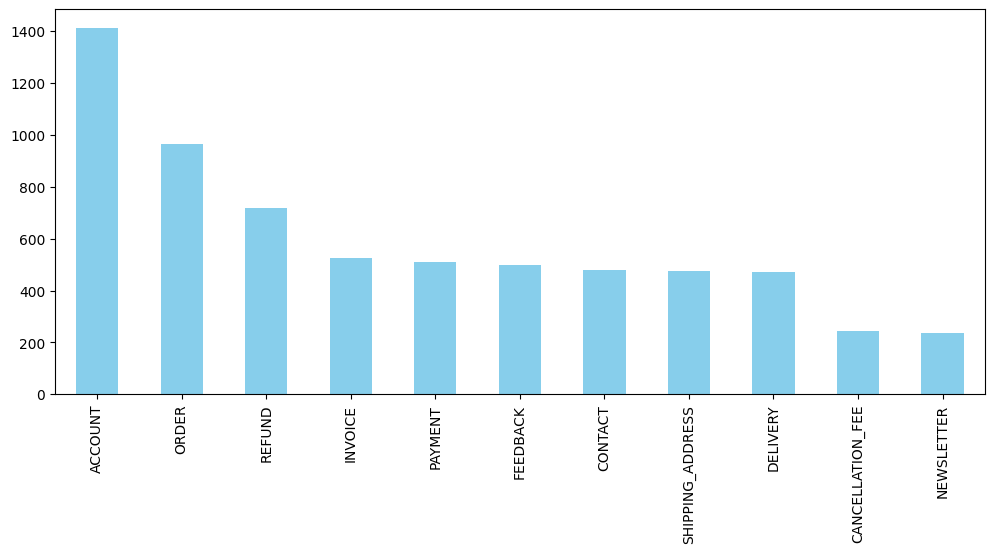

In [19]:
full_df['category'].value_counts(sort=True).plot.bar(figsize=(12, 5), color='skyblue')

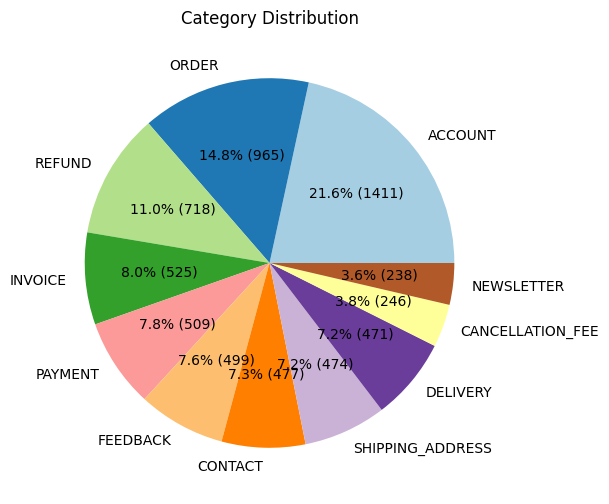

In [20]:
value_counts = full_df['category'].value_counts()

colors = plt.cm.Paired(np.linspace(0, 1, len(value_counts)))
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', colors=colors)
plt.title('Category Distribution')
plt.show()

In [21]:
full_df.describe()

,number_of_tokens
count,6539.000000
mean,8.851812
std,2.531762
min,1.000000
25%,7.000000
50%,9.000000
75%,11.000000
max,16.000000


In [24]:
df = full_df.sample(frac=1).reset_index(drop=True)  # random order
df = df[:400]

In [25]:
# Creating the training, validation & test dataframes
ds_train, ds_temp = train_test_split(df, test_size=0.3, stratify=df['category'], random_state=45)
ds_val, ds_test = train_test_split(ds_temp, test_size=0.5, stratify=ds_temp['category'], random_state=45)

<Axes: >

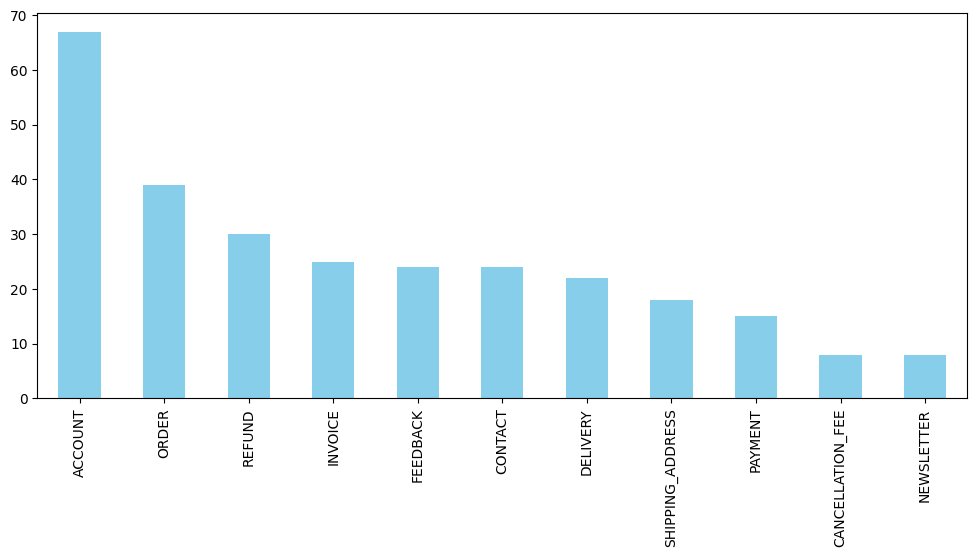

In [26]:
ds_train['category'].value_counts(sort=True).plot.bar(figsize=(12, 5), color='skyblue')

In [27]:
total_size = len(ds_train) + len(ds_val) + len(ds_test)
train_percent = (len(ds_train) / total_size) * 100
val_percent = (len(ds_val) / total_size) * 100
test_percent = (len(ds_test) / total_size) * 100

print(f"Training size   = {len(ds_train):5} ({train_percent:.2f}%)")
print(f"Validation size = {len(ds_val):5} ({val_percent:.2f}%)")
print(f"Test size       = {len(ds_test):5} ({test_percent:.2f}%)")

Training size   =   280 (70.00%)
Validation size =    60 (15.00%)
Test size       =    60 (15.00%)


In [28]:
categories_df = ds_train.category.unique().tolist()
categories_df

['ORDER',
 'ACCOUNT',
 'CANCELLATION_FEE',
 'FEEDBACK',
 'PAYMENT',
 'REFUND',
 'NEWSLETTER',
 'CONTACT',
 'SHIPPING_ADDRESS',
 'DELIVERY',
 'INVOICE']

In [29]:
print(f"Total number of categories = {len(categories_df)}")

Total number of categories = 11


In [30]:
categories = ', '.join(categories_df)
categories

'ORDER, ACCOUNT, CANCELLATION_FEE, FEEDBACK, PAYMENT, REFUND, NEWSLETTER, CONTACT, SHIPPING_ADDRESS, DELIVERY, INVOICE'

### Prompt

In [32]:
prompt = f"You are a call center agent. Your task is to categorize customer request. Please categorize the customer request into one of these {len(categories_df)} categories: {categories}. Just print the category name, nothing else. If you are unsure, please use 'UNKNOWN'."

print(prompt)

You are a call center agent. Your task is to categorize customer request. Please categorize the customer request into one of these 11 categories: ORDER, ACCOUNT, CANCELLATION_FEE, FEEDBACK, PAYMENT, REFUND, NEWSLETTER, CONTACT, SHIPPING_ADDRESS, DELIVERY, INVOICE. Just print the category name, nothing else. If you are unsure, please use 'UNKNOWN'.


### Creating the jsonl files

In [34]:
training_jsonl = 'customer_training.jsonl'

In [35]:
json_train_list = []

for index, row in ds_train.iterrows():
    json_obj = {
        "messages": [
            {
                "role": "system", "content": str(prompt)
            },
            {
                "role": "user", "content": str(row["text"])
            },  
            {
                "role": "assistant", "content": str(row["category"])
            },
        ]
    }
    json_train_list.append(json_obj)

# Saving into the jsonl file
with open(training_jsonl, "w") as f:
    for json_obj in json_train_list:
        f.write(json.dumps(json_obj) + "\n")

In [36]:
validation_jsonl = 'customer_validation.jsonl'

In [37]:
json_val_list = []

for index, row in ds_val.iterrows():
    json_obj = {
        "messages": [
            {
                "role": "system", "content": str(prompt)
            },
            {
                "role": "user", "content": str(row["text"])
            },  
            {
                "role": "assistant", "content": str(row["category"])
            }
        ]
    }
    json_val_list.append(json_obj)

# Saving into the jsonl file
with open(validation_jsonl, "w") as f:
    for json_obj in json_val_list:
        f.write(json.dumps(json_obj) + "\n")

In [38]:
!ls *.jsonl -lh

-rwxrwxrwx 1 root root 142K Feb  6 10:20 customer_training.jsonl
-rwxrwxrwx 1 root root  31K Feb  6 10:20 customer_validation.jsonl


### Uploading the jsonl files into Azure AI Foundry

In [39]:
train_file = aoai_client.files.create(file=open(training_jsonl, "rb"), purpose="fine-tune")

In [40]:
val_file = aoai_client.files.create(file=open(validation_jsonl, "rb"), purpose="fine-tune")

In [41]:
train_file

FileObject(id='file-0c98ff00ebdb4054aff6edce70249315', bytes=145399, created_at=1738837265, filename='customer_training.jsonl', object='file', purpose='fine-tune', status='pending', status_details=None)

In [42]:
val_file

FileObject(id='file-008d6e3a091a4ba1b3de649d3c396407', bytes=31138, created_at=1738837266, filename='customer_validation.jsonl', object='file', purpose='fine-tune', status='pending', status_details=None)

In [43]:
print(f"File name:  {train_file.filename}")
print(f"File size:  {(train_file.bytes / (1024 * 1024)):.2f} MB")
print(f"Created at: {datetime.fromtimestamp(train_file.created_at)}")

File name:  customer_training.jsonl
File size:  0.14 MB
Created at: 2025-02-06 10:21:05


In [44]:
print(f"File name:  {val_file.filename}")
print(f"File size:  {(val_file.bytes / (1024 * 1024)):.2f} MB")
print(f"Created at: {datetime.fromtimestamp(val_file.created_at)}")

File name:  customer_validation.jsonl
File size:  0.03 MB
Created at: 2025-02-06 10:21:06


## 3. Running the fine tuning job

In [45]:
# Create fine tuning job
file_train = train_file.id
file_val = val_file.id

ft_job = aoai_client.fine_tuning.jobs.create(
    suffix=project_name,
    training_file=file_train,
    validation_file=file_val,
    model=baseline_model,
    method="sft",  # sft=Supervised Fine tuning (default method). DPO is available as well.
    seed=None,  # Seed to ensure the same randomization and consistent training results across runs. If no seed is specified, one will be generated.
    hyperparameters={
        "n_epochs": None,  # Number of epochs (passes through the entire dataset). 'Auto' by default.
        "batch_size": None,  # Number of examples per batch. 'Auto' by default.
        "learning_rate_multiplier": None  # Scale factor for the learning rate. 'Auto' by default.
    })

- **seed**	The seed controls the reproducibility of the job. Passing in the same seed and job parameters should produce the same results, but may differ in rare cases. If a seed isn't specified, one will be generated for you.
- **n_epoch** The number of epochs to train the model for. An epoch refers to one full cycle through the training dataset.
- **batch_size** The batch size to use for training. The batch size is the number of training examples used to train a single forward and backward pass. In general, we've found that larger batch sizes tend to work better for larger datasets. The default value as well as the maximum value for this property are specific to a base model. A larger batch size means that model parameters are updated less frequently, but with lower variance.
- **learning_rate_multiplier** The learning rate multiplier to use for training. The fine-tuning learning rate is the original learning rate used for pre-training multiplied by this value. Larger learning rates tend to perform better with larger batch sizes. We recommend experimenting with values in the range 0.02 to 0.2 to see what produces the best results. A smaller learning rate can be useful to avoid overfitting.

Documentation: https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning

Default method is **Supervised Fine-Tuning (SFT)**.

**Direct Preference Optimization (DPO)** method is also available:
https://techcommunity.microsoft.com/blog/azure-ai-services-blog/announcing-public-preview-of-direct-preference-optimization-capabilities-with-az/4358164

In [46]:
ft_job

FineTuningJob(id='ftjob-c40e7b411fae4e75a63042e6a4cbcf6d', created_at=1738837274, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=-1, learning_rate_multiplier=1.0, n_epochs=-1), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id=None, result_files=None, seed=1718536147, status='pending', trained_tokens=None, training_file='file-0c98ff00ebdb4054aff6edce70249315', validation_file='file-008d6e3a091a4ba1b3de649d3c396407', estimated_finish=1738838190, integrations=None, method=None, suffix='callcenter')

In [47]:
get_ft_job_definition()

 {'id': 'ftjob-c40e7b411fae4e75a63042e6a4cbcf6d', 'created_at': 1738837274, 'hyperparameters': {'batch_size': -1, 'learning_rate_multiplier': 1.0, 'n_epochs': -1}, 'model': 'gpt-4o-2024-08-06', 'object': 'fine_tuning.job', 'seed': 1718536147, 'status': 'pending', 'training_file': 'file-0c98ff00ebdb4054aff6edce70249315', 'validation_file': 'file-008d6e3a091a4ba1b3de649d3c396407', 'estimated_finish': 1738838190, 'suffix': 'callcenter'}


{'id': 'ftjob-c40e7b411fae4e75a63042e6a4cbcf6d',
 'created_at': 1738837274,
 'hyperparameters': {'batch_size': -1,
  'learning_rate_multiplier': 1.0,
  'n_epochs': -1},
 'model': 'gpt-4o-2024-08-06',
 'object': 'fine_tuning.job',
 'seed': 1718536147,
 'status': 'pending',
 'training_file': 'file-0c98ff00ebdb4054aff6edce70249315',
 'validation_file': 'file-008d6e3a091a4ba1b3de649d3c396407',
 'estimated_finish': 1738838190,
 'suffix': 'callcenter'}

In [48]:
job_id = ft_job.to_dict()['id']
job_id

'ftjob-c40e7b411fae4e75a63042e6a4cbcf6d'

In [49]:
get_ft_job_info(job_id)

2025-02-06 10:21:19
Job ID: ftjob-c40e7b411fae4e75a63042e6a4cbcf6d
Status: pending
{
   "id": "ftjob-c40e7b411fae4e75a63042e6a4cbcf6d",
   "created_at": 1738837274,
   "error": null,
   "fine_tuned_model": null,
   "finished_at": null,
   "hyperparameters": {
      "batch_size": -1,
      "learning_rate_multiplier": 1.0,
      "n_epochs": -1
   },
   "model": "gpt-4o-2024-08-06",
   "object": "fine_tuning.job",
   "organization_id": null,
   "result_files": null,
   "seed": 1718536147,
   "status": "pending",
   "trained_tokens": null,
   "training_file": "file-0c98ff00ebdb4054aff6edce70249315",
   "validation_file": "file-008d6e3a091a4ba1b3de649d3c396407",
   "estimated_finish": 1738838190,
   "integrations": null,
   "method": null,
   "suffix": "callcenter"
}


### Latest fine-tuning jobs

In [50]:
ft_jobs = aoai_client.fine_tuning.jobs.list(limit=5).to_dict()
date_sorted_df(pd.DataFrame(ft_jobs['data']))

,id,created_at,hyperparameters,model,object,seed,status,training_file,validation_file,estimated_finish,suffix,fine_tuned_model,finished_at,result_files,trained_tokens
0,ftjob-c40e7b411fae4e75a63042e6a4cbcf6d,2025-02-06 10:21:14,"{'batch_size': -1, 'learning_rate_multiplier':...",gpt-4o-2024-08-06,fine_tuning.job,1718536147,pending,file-0c98ff00ebdb4054aff6edce70249315,file-008d6e3a091a4ba1b3de649d3c396407,1738838190,callcenter,NaN,NaN,NaN,NaN
1,ftjob-82d7922a32084532a1d98f2d11e56c06,2025-01-23 16:53:53,"{'batch_size': 1, 'learning_rate_multiplier': ...",gpt-4o-mini-2024-07-18,fine_tuning.job,1456135482,succeeded,file-7dd235fe7b0146d0bfccccf4fd177632,file-ad5e1cd0829a4421a3c7c2807b84fee0,1737652138,callcenterclassification,gpt-4o-mini-2024-07-18.ft-82d7922a32084532a1d9...,2025-02-03 13:27:45,[file-b5efc313fd024286a0e8263108bea7cf],27114.0
2,ftjob-0c5a44718cc44e519d442a8d45f6b341,2025-01-22 15:24:52,"{'batch_size': 1, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,918353715,succeeded,file-74b4a99308ab4facb56b8254755f9acf,file-0fb1d128e599433d998be72713b733a3,1737560652,metaldefects-gpt4o,gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d4...,2025-02-03 13:26:43,[file-9df1bcd2a40141d49e30e426e7f1a408],1734588.0
3,ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3,2025-01-20 08:03:24,"{'batch_size': 2, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,971325359,succeeded,file-2fdc3057ff54489fb9b0c9518b34aa53,file-518d9c12b190445e988a1b257cd33379,1737367737,vqa-gpt4o,gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f...,2025-01-20 12:41:27,[file-b1b0c191277f444999a131bd437a6855],44224200.0


## Checking the status (from pending to running to succeeded)

In [51]:
response = aoai_client.fine_tuning.jobs.retrieve(job_id)
status = response.status

while status not in ["succeeded", "failed"]:
    response = aoai_client.fine_tuning.jobs.retrieve(job_id)
    status = response.status
    print("\033[1;31;34m")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    response = aoai_client.fine_tuning.jobs.retrieve(job_id)
    print("\n", response.model_dump_json(indent=4))
    status = response.status
    print(f'\nStatus: {status.upper()}')
    clear_output(wait=True)  # Auto refresh current cell every 30 secs as specified below
    time.sleep(30)

print(f"Fine-tuning job {job_id} finished with status: {status}")

Fine-tuning job ftjob-c40e7b411fae4e75a63042e6a4cbcf6d finished with status: succeeded


## 4. Job status

You can check the status of the Azure AI Foundry portal as well.

In [52]:
get_ft_status(job_id)

2025-02-06 12:09:09
Job status of ftjob-c40e7b411fae4e75a63042e6a4cbcf6d: succeeded


In [53]:
get_ft_job_info(job_id)

2025-02-06 12:09:09
Job ID: ftjob-c40e7b411fae4e75a63042e6a4cbcf6d
Status: succeeded
{
   "id": "ftjob-c40e7b411fae4e75a63042e6a4cbcf6d",
   "created_at": 1738837274,
   "error": null,
   "fine_tuned_model": "gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a4cbcf6d-callcenter",
   "finished_at": 1738843690,
   "hyperparameters": {
      "batch_size": 1,
      "learning_rate_multiplier": 1.0,
      "n_epochs": 3
   },
   "model": "gpt-4o-2024-08-06",
   "object": "fine_tuning.job",
   "organization_id": null,
   "result_files": [
      "file-14529be0515648e8bccdb77e620f1f0b"
   ],
   "seed": 1718536147,
   "status": "succeeded",
   "trained_tokens": 108837,
   "training_file": "file-0c98ff00ebdb4054aff6edce70249315",
   "validation_file": "file-008d6e3a091a4ba1b3de649d3c396407",
   "estimated_finish": 1738838190,
   "integrations": null,
   "method": null,
   "suffix": "callcenter"
}


In [54]:
# Retrieve the state of a fine-tune job
ft_job = aoai_client.fine_tuning.jobs.retrieve(job_id)
ft_job.to_dict()

{'id': 'ftjob-c40e7b411fae4e75a63042e6a4cbcf6d',
 'created_at': 1738837274,
 'fine_tuned_model': 'gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a4cbcf6d-callcenter',
 'finished_at': 1738843690,
 'hyperparameters': {'batch_size': 1,
  'learning_rate_multiplier': 1.0,
  'n_epochs': 3},
 'model': 'gpt-4o-2024-08-06',
 'object': 'fine_tuning.job',
 'result_files': ['file-14529be0515648e8bccdb77e620f1f0b'],
 'seed': 1718536147,
 'status': 'succeeded',
 'trained_tokens': 108837,
 'training_file': 'file-0c98ff00ebdb4054aff6edce70249315',
 'validation_file': 'file-008d6e3a091a4ba1b3de649d3c396407',
 'estimated_finish': 1738838190,
 'suffix': 'callcenter'}

In [55]:
start_dt = datetime.fromtimestamp(ft_job.to_dict()['created_at'])
end_dt = datetime.fromtimestamp(ft_job.to_dict()['finished_at'])

print(f"{start_dt} Model training starts")
print(f"{end_dt} End of model training")
print(f"Training duration: {(end_dt - start_dt)}")
trained_tokens = ft_job.to_dict()["trained_tokens"]
print(f"Number of trained tokens: {trained_tokens:,}")

2025-02-06 10:21:14 Model training starts
2025-02-06 12:08:10 End of model training
Training duration: 1:46:56
Number of trained tokens: 108,837


## 5. Metrics
You can check the metrics of the Azure AI Foundry portal as well.

In [56]:
data_io = StringIO(aoai_client.files.content(ft_job.to_dict()['result_files'][0]).content.decode())
results_df = pd.read_csv(data_io)
results_df

,step,train_loss,train_mean_token_accuracy,train_error_rate,valid_loss,valid_mean_token_accuracy,valid_error_rate,full_valid_loss,full_valid_mean_token_accuracy,full_valid_error_rate,rollout.reward/grade,test_set/mean_reward
0,1,0.002886,1.000000,NaN,0.001381,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.001554,1.000000,NaN,0.003025,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.028144,1.000000,NaN,0.001523,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.020215,1.000000,NaN,0.159286,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.000238,1.000000,NaN,0.000490,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,0.000902,0.000000,NaN,0.000491,0.500000,NaN,NaN,NaN,NaN,NaN,NaN
836,837,0.000120,0.600000,NaN,0.000221,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
837,838,0.000199,0.333333,NaN,0.000250,0.500000,NaN,NaN,NaN,NaN,NaN,NaN
838,839,0.000206,0.333333,NaN,0.000160,0.333333,NaN,NaN,NaN,NaN,NaN,NaN


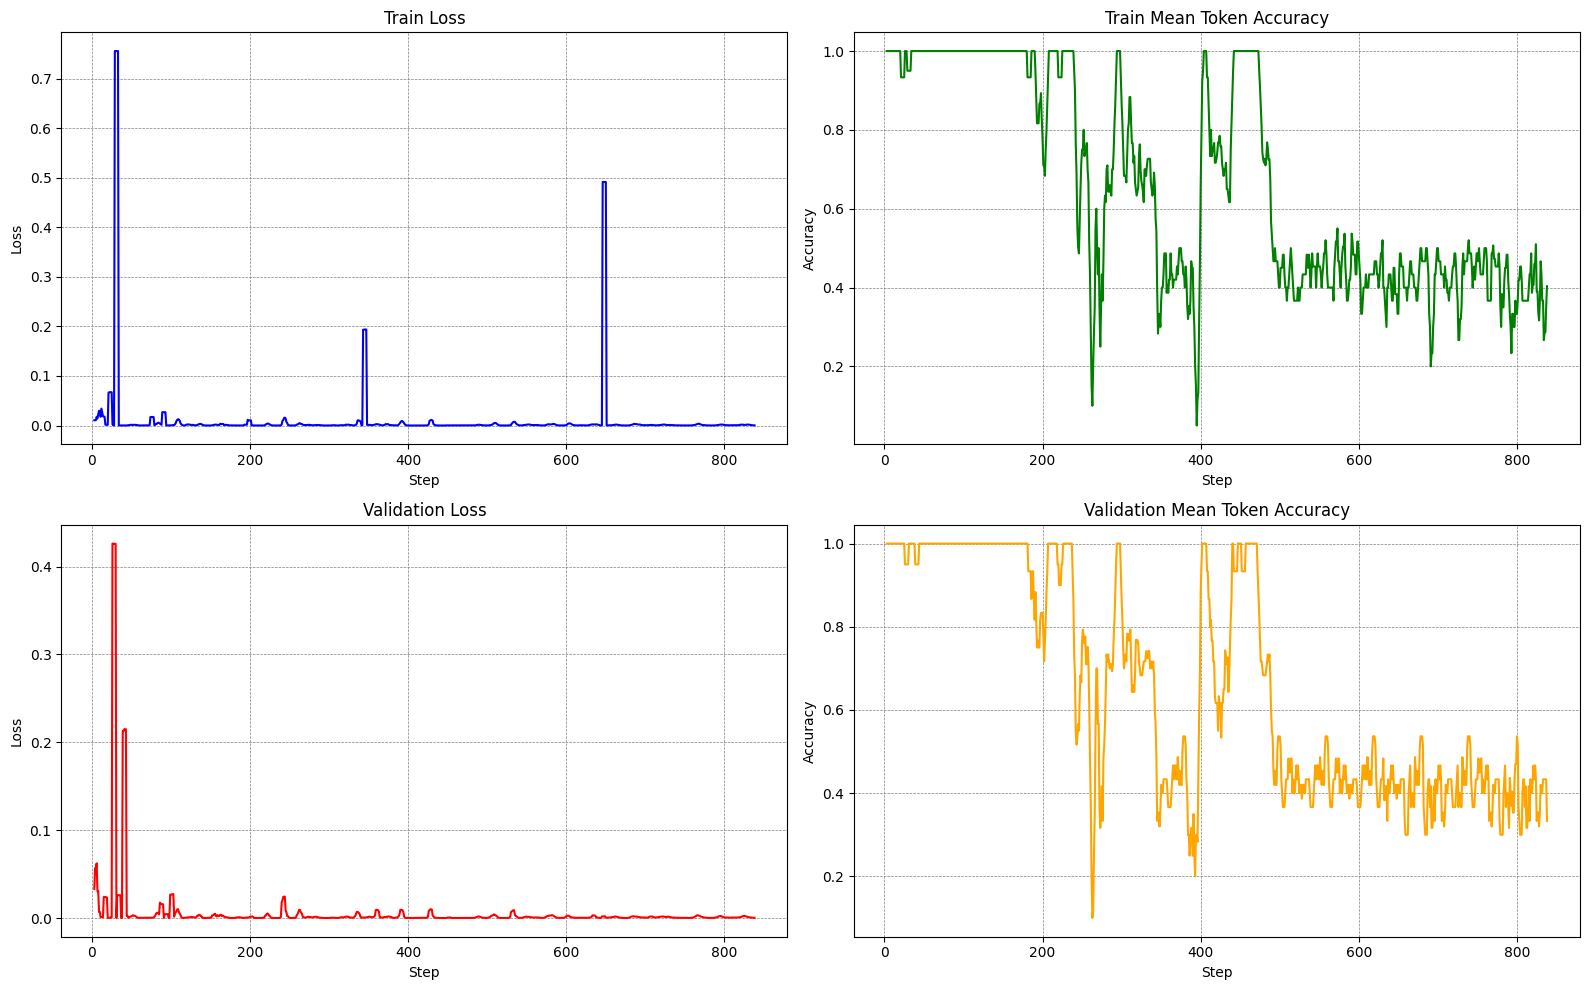

In [57]:
show_ft_metrics(results_df)

In [58]:
metrics_xl_file = f"{project_name}_metrics.xlsx"

results_df.to_excel(metrics_xl_file, index=False)
!ls $metrics_xl_file -lh

-rwxrwxrwx 1 root root 54K Feb  6 12:28 callcenter_metrics.xlsx


## 6. Model deployment

In [59]:
my_models = aoai_client.models.list().to_dict()

models_df = date_sorted_df(my_models['data'])
cols = ['status', 'capabilities', 'lifecycle_status', 'id', 'created_at', 'model']
bold_start, bold_end = '\033[1m', '\033[0m'
print(f"Models of Azure OpenAI resource {bold_start}{resource_name}{bold_end}:")
display(models_df[cols].head())

Models of Azure OpenAI resource azureopenai-sweden-sr:


,status,capabilities,lifecycle_status,id,created_at,model
88,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a...,2025-02-06 10:21:14,gpt-4o-2024-08-06
87,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a...,2025-02-06 10:21:14,gpt-4o-2024-08-06
86,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a...,2025-02-06 10:21:14,gpt-4o-2024-08-06
32,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",preview,gpt-4o-mini-audio-preview-2024-12-17,2025-02-03 00:00:00,NaN
85,succeeded,"{'fine_tune': True, 'inference': True, 'comple...",generally-available,gpt-4o-mini-2024-07-18.ft-82d7922a32084532a1d9...,2025-01-23 16:53:53,gpt-4o-mini-2024-07-18


In [60]:
models_df

,id,object,status,capabilities,lifecycle_status,deprecation,created_at,model,fine_tune
88,gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-02-06 10:21:14,gpt-4o-2024-08-06,ftjob-c40e7b411fae4e75a63042e6a4cbcf6d
87,gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-02-06 10:21:14,gpt-4o-2024-08-06,ftjob-c40e7b411fae4e75a63042e6a4cbcf6d
86,gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-02-06 10:21:14,gpt-4o-2024-08-06,ftjob-c40e7b411fae4e75a63042e6a4cbcf6d
32,gpt-4o-mini-audio-preview-2024-12-17,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",preview,"{'fine_tune': 1763424000, 'inference': 1763424...",2025-02-03 00:00:00,NaN,NaN
85,gpt-4o-mini-2024-07-18.ft-82d7922a32084532a1d9...,model,succeeded,"{'fine_tune': True, 'inference': True, 'comple...",generally-available,{'inference': 1747699200},2025-01-23 16:53:53,gpt-4o-mini-2024-07-18,ftjob-82d7922a32084532a1d98f2d11e56c06
...,...,...,...,...,...,...,...,...,...
52,text-similarity-curie-001,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1718323200},2022-05-20 00:00:00,NaN,NaN
55,davinci,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN
36,ada,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN
51,curie,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN


In [61]:
fine_tuned_model = models_df['id'].values[0].split(':')[0]
fine_tuned_model

'gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a4cbcf6d-callcenter'

In [62]:
api_version = "2023-05-01"  # subject to change in the future
sku_capacity = 1
model_version = 1

aoai_deployment_name = project_name  # AOAI deployment name. Use as model parameter for inferencing
credential = DefaultAzureCredential()
token = credential.get_token("https://management.azure.com/.default").token

deploy_params = {'api-version': api_version}

deploy_headers = {
    'Authorization': 'Bearer {}'.format(token),
    'Content-Type': 'application/json'
}

deploy_data = {
    "sku": {
        "name": "standard",
        "capacity": sku_capacity,
    },
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": fine_tuned_model,
            "version": model_version,
        }
    }
}

deploy_data = json.dumps(deploy_data)

request_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{rg_name}/providers/Microsoft.CognitiveServices/accounts/{resource_name}/deployments/{aoai_deployment_name}"

In [63]:
print("\033[1;31;34m")
print(json.dumps(json.loads(deploy_data), indent=4))


{
    "sku": {
        "name": "standard",
        "capacity": 1
    },
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": "gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a4cbcf6d-callcenter",
            "version": 1
        }
    }
}


In [64]:
print("Creating a new deployment")

req = requests.put(request_url,
                   params=deploy_params,
                   headers=deploy_headers,
                   data=deploy_data)

Creating a new deployment


### Status of the deployed model

> Please wait a couple of minutes until the completion of the deployed model.

In [65]:
print("\033[1;31;34m")
print(f"Status: {req}")
print(f"Reason: {req.reason}")


Status: <Response [201]>
Reason: Created


In [66]:
print("\033[1;31;34m")
print(json.dumps(req.json(), indent=4))


{
    "id": "/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureopenai-suede-rg/providers/Microsoft.CognitiveServices/accounts/azureopenai-sweden-sr/deployments/callcenter",
    "type": "Microsoft.CognitiveServices/accounts/deployments",
    "name": "callcenter",
    "sku": {
        "name": "standard",
        "capacity": 1
    },
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": "gpt-4o-2024-08-06.ft-c40e7b411fae4e75a63042e6a4cbcf6d-callcenter",
            "version": "1"
        },
        "versionUpgradeOption": "NoAutoUpgrade",
        "capabilities": {
            "area": "EUR",
            "chatCompletion": "true",
            "assistants": "true",
            "jsonSchemaResponse": "true",
            "maxContextToken": "128000",
            "maxOutputToken": "16384"
        },
        "provisioningState": "Creating",
        "rateLimits": [
            {
                "key": "request",
                "renewalPeri

## 7. Testing the deployed model

In [67]:
ds_test

,text,category,number_of_tokens
243,I need assistance buying something,ORDER,5
148,change to my other user profile,ACCOUNT,6
228,I want assistance to chat with a person,CONTACT,8
18,could you help me get the invoice from my last...,INVOICE,12
309,show me what hours I can contact customer service,CONTACT,9
112,tell me about the delivery period,DELIVERY,6
50,I don't know how I could check my refund status,REFUND,11
102,I have forgotten to include an item,ORDER,7
187,I need help to check when my item is going to ...,DELIVERY,12
279,i have a goddamn trouble registering,ACCOUNT,7


In [90]:
#@retry(stop=stop_after_attempt(3), wait=wait_fixed(5))
def calling_classification_model(text, model):
    """
    Calls the classification model.

    Parameters:
    text (str): The customer request or text to be classified.
    model (str): The model identifier to be used for classification.

    Returns:
    str: The classification result from the model.
    """
    response = aoai_client.chat.completions.create(
        model=model,
        messages=[{
            "role": "system",
            "content": prompt
        }, {
            "role":
            "user",
            "content": [{
                "type": "text",
                "text": text
            }, 
                       ]
        }],
        temperature=0,
        max_tokens=8000,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )

    return response.choices[0].message.content

### Quick test

In [91]:
idx = 15

text = f"{ds_test.iloc[idx]['text']}"
target_cat = ds_test.iloc[idx]['category']
print("\033[1;31;34m")
print("Initial text:")
print(text)
print("\033[1;31;32m")
print(f"True category is: {target_cat}")


Initial text:
would you give me information about order cancellations?

True category is: ORDER


#### Using the baseline model

In [92]:
GREEN = "\033[92m"
RED = "\033[91m"
RESET = "\033[0m"

In [93]:
pred_cat = calling_classification_model(text, model)  # using the baseline model
print(f"True category: {target_cat}")
print(f"Predicted category using the baseline model {baseline_model}: {pred_cat}")
print(f"\n[Conclusion] Prediction is {GREEN if pred_cat == target_cat else RED}{'CORRECT' if pred_cat == target_cat else 'INCORRECT'}{RESET}")

True category: ORDER
Predicted category using the baseline model gpt-4o-2024-08-06: UNKNOWN

[Conclusion] Prediction is INCORRECT


#### Using the fine-tuned model

In [101]:
pred_cat = calling_classification_model(text, project_name)  # using the fine-tuned model
print(f"True answer: {target_cat}")
print(f"Predicted category using the fine-tuned model {baseline_model}: {pred_cat}")
print(f"\n[Conclusion] Prediction is {GREEN if pred_cat == target_cat else RED}{'CORRECT' if pred_cat == target_cat else 'INCORRECT'}{RESET}")

True answer: ORDER
Predicted category using the fine-tuned model gpt-4o-2024-08-06: ORDER

[Conclusion] Prediction is CORRECT


### Processing the test dataset using the baseline model

In [74]:
# Process the test df with baseline model
print("Baseline model:", baseline_model)

tqdm.pandas()
ds_test['gpt-4o-base-pred'] = ds_test.progress_apply(
    lambda row: calling_classification_model(f"{row['text']}", model),
    axis=1
)

Baseline model: gpt-4o-2024-08-06


100%|██████████| 60/60 [01:02<00:00,  1.05s/it]


In [75]:
ds_test

,text,category,number_of_tokens,gpt-4o-base-pred
243,I need assistance buying something,ORDER,5,ORDER
148,change to my other user profile,ACCOUNT,6,ACCOUNT
228,I want assistance to chat with a person,CONTACT,8,CONTACT
18,could you help me get the invoice from my last...,INVOICE,12,INVOICE
309,show me what hours I can contact customer service,CONTACT,9,CONTACT
112,tell me about the delivery period,DELIVERY,6,DELIVERY
50,I don't know how I could check my refund status,REFUND,11,REFUND
102,I have forgotten to include an item,ORDER,7,ORDER
187,I need help to check when my item is going to ...,DELIVERY,12,DELIVERY
279,i have a goddamn trouble registering,ACCOUNT,7,ACCOUNT


### Processing the test dataset using the fine-tuned model

In [102]:
# Process test df with the fine-tuned model
print("Fine-tuned model:", project_name)

tqdm.pandas()
ds_test['gpt-4o-ft-pred'] = ds_test.progress_apply(
    lambda row: calling_classification_model(f"{row['text']}", project_name),
    axis=1
)

Fine-tuned model: callcenter


100%|██████████| 60/60 [01:50<00:00,  1.85s/it]


In [103]:
ds_test

,text,category,number_of_tokens,gpt-4o-base-pred,gpt-4o-ft-pred
243,I need assistance buying something,ORDER,5,ORDER,ORDER
148,change to my other user profile,ACCOUNT,6,ACCOUNT,ACCOUNT
228,I want assistance to chat with a person,CONTACT,8,CONTACT,CONTACT
18,could you help me get the invoice from my last...,INVOICE,12,INVOICE,INVOICE
309,show me what hours I can contact customer service,CONTACT,9,CONTACT,CONTACT
112,tell me about the delivery period,DELIVERY,6,DELIVERY,DELIVERY
50,I don't know how I could check my refund status,REFUND,11,REFUND,REFUND
102,I have forgotten to include an item,ORDER,7,ORDER,ORDER
187,I need help to check when my item is going to ...,DELIVERY,12,DELIVERY,DELIVERY
279,i have a goddamn trouble registering,ACCOUNT,7,ACCOUNT,ACCOUNT


## 8. Confusion matrix

### Confusion matrix of the baseline model

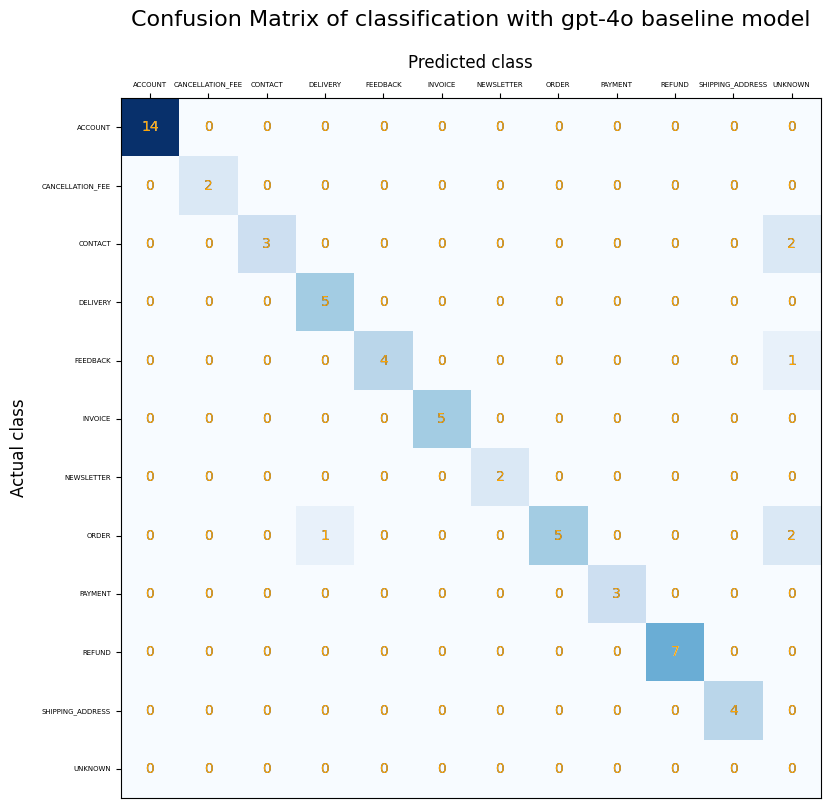

In [82]:
y_true = ds_test[['category']].to_numpy()
y_pred = ds_test[['gpt-4o-base-pred']].to_numpy()
labels = np.unique(np.concatenate([y_true, y_pred]))

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j,
            i,
            f"{value}",
            ha="center",
            va="center",
            fontsize=10,
            color="orange")

ax.set_title(
    "Confusion Matrix of classification with gpt-4o baseline model",
    fontsize=16,
    pad=20)

ax.set_xlabel("Predicted class", fontsize=12, labelpad=10)
ax.set_ylabel("Actual class", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='major', labelsize=5)
ax.grid(which="minor", color="black", linestyle="--", linewidth=1)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.15, right=0.85)
plt.savefig("confmatrix_baseline.png")
plt.show()

In [83]:
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

                  precision    recall  f1-score   support

         ACCOUNT       1.00      1.00      1.00        14
CANCELLATION_FEE       1.00      1.00      1.00         2
         CONTACT       1.00      0.60      0.75         5
        DELIVERY       0.83      1.00      0.91         5
        FEEDBACK       1.00      0.80      0.89         5
         INVOICE       1.00      1.00      1.00         5
      NEWSLETTER       1.00      1.00      1.00         2
           ORDER       1.00      0.62      0.77         8
         PAYMENT       1.00      1.00      1.00         3
          REFUND       1.00      1.00      1.00         7
SHIPPING_ADDRESS       1.00      1.00      1.00         4
         UNKNOWN       0.00      0.00      0.00         0

        accuracy                           0.90        60
       macro avg       0.90      0.84      0.86        60
    weighted avg       0.99      0.90      0.93        60



In [78]:
accuracy_base = np.diag(cm).sum() / cm.sum()
print("\033[1;31;34m")
print(f"GPT-4o baseline model accuracy = {accuracy_base * 100:.2f}%")


GPT-4o baseline model accuracy = 90.00%


### Confusion matrix of the fine tuned model

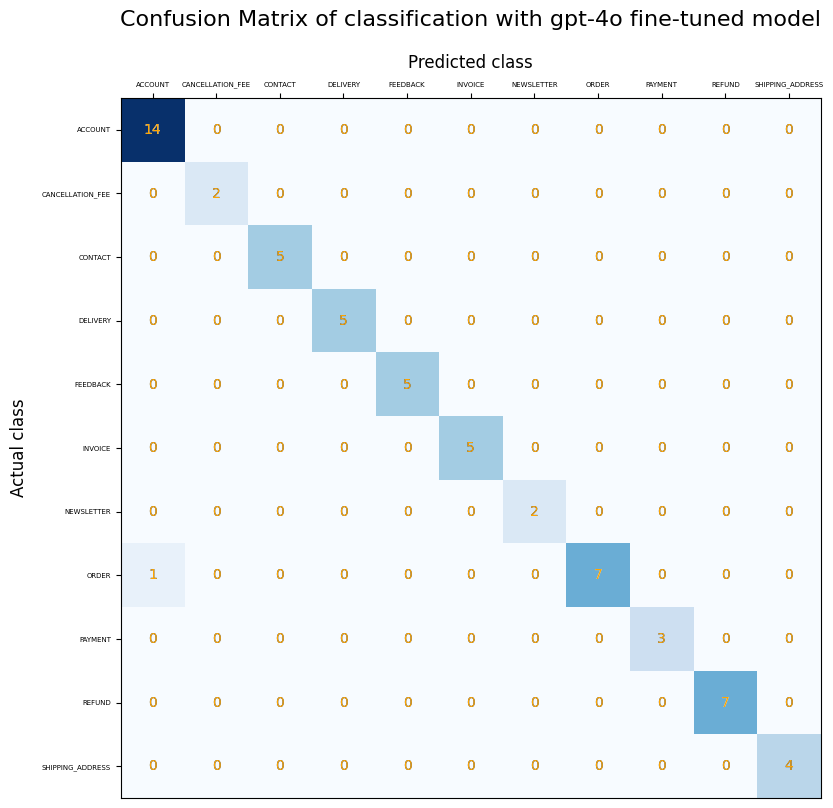

In [112]:
y_true = ds_test[['category']].to_numpy()
y_pred = ds_test[['gpt-4o-ft-pred']].to_numpy()
labels = np.unique(np.concatenate([y_true, y_pred]))

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j,
            i,
            f"{value}",
            ha="center",
            va="center",
            fontsize=10,
            color="orange")

ax.set_title(
    "Confusion Matrix of classification with gpt-4o fine-tuned model",
    fontsize=16,
    pad=20)

ax.set_xlabel("Predicted class", fontsize=12, labelpad=10)
ax.set_ylabel("Actual class", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='major', labelsize=5)
ax.grid(which="minor", color="gray", linestyle="--", linewidth=1)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.15, right=0.85)
plt.savefig("confmatrix_ft.png")
plt.show()

In [105]:
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

                  precision    recall  f1-score   support

         ACCOUNT       0.93      1.00      0.97        14
CANCELLATION_FEE       1.00      1.00      1.00         2
         CONTACT       1.00      1.00      1.00         5
        DELIVERY       1.00      1.00      1.00         5
        FEEDBACK       1.00      1.00      1.00         5
         INVOICE       1.00      1.00      1.00         5
      NEWSLETTER       1.00      1.00      1.00         2
           ORDER       1.00      0.88      0.93         8
         PAYMENT       1.00      1.00      1.00         3
          REFUND       1.00      1.00      1.00         7
SHIPPING_ADDRESS       1.00      1.00      1.00         4

        accuracy                           0.98        60
       macro avg       0.99      0.99      0.99        60
    weighted avg       0.98      0.98      0.98        60



In [106]:
accuracy_ft = np.diag(cm).sum() / cm.sum()
print("\033[1;31;34m")
print(f"GPT-4o fine-tuned model accuracy = {accuracy_ft * 100:.2f}%")


GPT-4o fine-tuned model accuracy = 98.33%


## 9. Models comparison

In [114]:
print("\033[1;31;34m")
print(f"GPT-4o baseline model accuracy   = {accuracy_base * 100:.2f}%")
print(f"GPT-4o fine-tuned model accuracy = {accuracy_ft * 100:.2f}%")


GPT-4o baseline model accuracy   = 90.00%
GPT-4o fine-tuned model accuracy = 98.33%


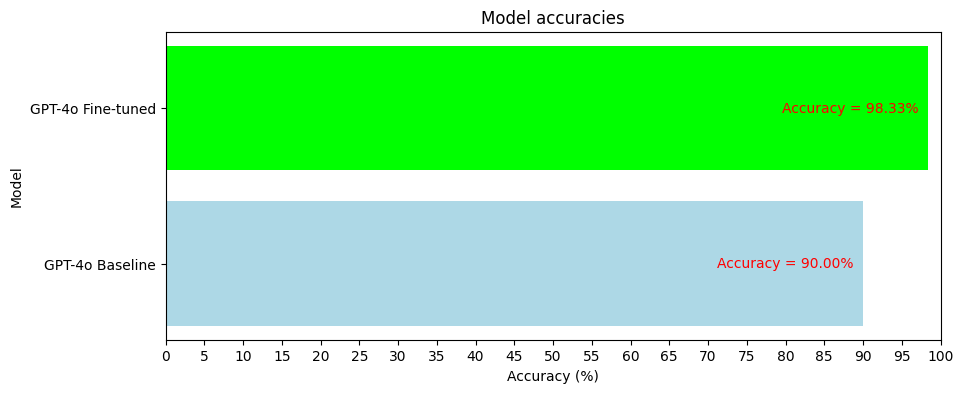

In [149]:
models = ['GPT-4o Baseline', 'GPT-4o Fine-tuned']
accuracies = [accuracy_base * 100, accuracy_ft * 100]
colors = ['lightblue', 'lime']

plt.figure(figsize=(10, 4))
bars = plt.barh(models, accuracies, color=colors)
plt.ylabel('Model')
plt.xlabel('Accuracy (%)')
plt.title('Model accuracies')
plt.xlim(0, 100)
plt.xticks(range(0, 101, 5))

for bar in bars:
    width = bar.get_width()
    plt.text(width - 10, bar.get_y() + bar.get_height() / 2, f'Accuracy = {width:.2f}%', ha='center', va='center', color='red')

# Show the plot
plt.show()

In [108]:
ds_test['Base-status'] = ds_test.apply(lambda row: 'CORRECT' if row['gpt-4o-base-pred'] == row['category'] else 'INCORRECT', axis=1)

In [109]:
ds_test['FT-status'] = ds_test.apply(lambda row: 'CORRECT' if row['gpt-4o-ft-pred'] == row['category'] else 'INCORRECT', axis=1)

base_incorrect = ds_test[ds_test['Base-status'] == 'INCORRECT']
ft_incorrect = ds_test[ds_test['FT-status'] == 'INCORRECT']

print("Rows where 'Base-status' is 'INCORRECT':")
base_incorrect

In [111]:
print("\nRows where 'FT-status' is 'INCORRECT':")
ft_incorrect


Rows where 'FT-status' is 'INCORRECT':


,text,category,number_of_tokens,gpt-4o-base-pred,gpt-4o-ft-pred,Base-status,FT-status
271,can you help me remove something?,ORDER,7,UNKNOWN,ACCOUNT,INCORRECT,INCORRECT


## 10. Exporting results

In [113]:
output_file = f"{project_name}_evaluation_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
output_excel_file = f"{output_file}.xlsx"

ds_test.to_excel(output_excel_file)
!ls $output_excel_file -lh

-rwxrwxrwx 1 root root 8.3K Feb  6 13:08 callcenter_evaluation_20250206_130852.xlsx


## 11. Azure AI Foundry portal

You can test the fine tuned model from the chat playground.

<img src="example.jpg">